In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
#from cartopy import crs, feature
#import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions23 import *

In [2]:
N = '/home/jvalenti/MOAD/analysis-jose/OParcels/Deploy_locations.csv'
MFc= 1e6
dtp= 10

In [3]:
def pandas_deploy(N,MFc,dtp):
    MFc = float(MFc)
    Rivers_deploy = pd.read_csv(N, index_col = [0])
    Pol = list(Rivers_deploy.Population_polluting)
    Lat = Rivers_deploy.Latitude
    Lon = Rivers_deploy.Longitude
    clat = []
    clon = []
    for i,loc in enumerate(Pol):
        for j in range(int(round((loc*25*dtp)/MFc,0))):
            clat.append(Lat.iat[i])
            clon.append(Lon.iat[i])
    return len(clat)  

In [4]:
pandas_deploy(N,MFc,24)

2651

In [5]:
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [6]:
path_d='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_T.nc'
path_d2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_w='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_W.nc'
path_w2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc'
path_u='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_U.nc'
path_v='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_V.nc'

path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
e3t2 = xr.open_dataset(path_d2,decode_times=False).e3t
e3t = xr.concat([e3t,e3t2],dim='time_counter')
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0
e3t0 = xr.open_dataset(path_mask,decode_times=False).e3t_0

In [7]:
ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,300,297:302]
ssh2 = xr.open_dataset(path_d2,decode_times=False).sossheig[:,300,297:302]
ssh = xr.concat([ssh,ssh2],dim='time_counter')
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,300,297:302]
u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,300,297:302]
w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,300,297:302]
w2 = xr.open_dataset(path_w2,decode_times=False).vovecrtz[:,:,300,297:302]
w = xr.concat([w,w2],dim='time_counter')
depthw = xr.open_dataset(path_w,decode_times=False).depthw
depthu = xr.open_dataset(path_u,decode_times=False).depthu
totaldepth = zz_ww[0, mbathy,300, 297:302]

In [8]:
totaldepth

<xarray.DataArray 'gdepw_0' (x: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: x

In [9]:
# ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,445,302:307]
# ssh2 = xr.open_dataset(path_d2,decode_times=False).sossheig[:,445,302:307]
# ssh = xr.concat([ssh,ssh2],dim='time_counter')
# mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,445,302:307]
# u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,445,302:307]
# w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,445,302:307]
# w2 = xr.open_dataset(path_w2,decode_times=False).vovecrtz[:,:,445,302:307]
# w = xr.concat([w,w2],dim='time_counter')
# depthw = xr.open_dataset(path_w,decode_times=False).depthw
# depthu = xr.open_dataset(path_u,decode_times=False).depthu
# totaldepth = zz_ww[0, mbathy,445,302:307]

In [10]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [11]:
print(totaldepth)

<xarray.DataArray 'gdepw_0' (x: 5)>
array([22.613064, 25.937412, 25.25    , 15.096255,  0.      ], dtype=float32)
Dimensions without coordinates: x


In [12]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [13]:
fieldset = FieldSet(U,V)
fieldset.add_field(W)
fieldset.add_field(SSH)
fieldset.add_field(Td)

In [14]:
class MPParticle(JITParticle):
    fact = Variable('fact', initial =  1.0) 

In [15]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [16]:
def Advection2(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt

In [17]:
def Advection3(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    sshn = fieldset.SSH[time+particle.dt, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    wssh = ((sshn-ssh)*particle.depth/(factor*(td+ssh)))/particle.dt
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]- wssh
    dep1 = particle.depth + w1*.5*particle.dt/factor
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]- wssh
    dep2 = particle.depth + w2*.5*particle.dt/factor
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]- wssh
    dep3 = particle.depth + w3*particle.dt/factor
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]- wssh
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt/factor

In [18]:
def Advection(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    sshn = fieldset.SSH[time+particle.dt, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    wssh = ((sshn-ssh)*particle.depth/(factor*(td+ssh)))
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt/factor
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt/factor
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt/factor
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt/factor -wssh/factor

In [19]:
def Advection_old(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    w1 =  fieldset.W[time , particle.depth/factor, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt/factor
    w2 =  fieldset.W[time + .5 * particle.dt, dep1/factor, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt/factor
    w3 = fieldset.W[time + .5 * particle.dt, dep2/factor, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt/factor
    w4 = fieldset.W[time + particle.dt, dep3/factor, particle.lat, particle.lon]
    sshn = fieldset.SSH[time+particle.dt, particle.depth, particle.lat, particle.lon]
    wssh = ((sshn-ssh)*particle.depth/(factor*(td+ssh)))/factor
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt/factor - wssh

In [20]:
n = 1000
KE=Advection
KE2=Advection2
KE3=Advection3
lon_g = np.random.uniform(low=250, high=2000, size=(n,))
depth_g = np.random.uniform(low=0.5, high=20, size=(n,))
lat_g = np.ones(n,)*750
pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
pset2 = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
pset3 = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
output_file = pset.ParticleFile(name='/home/jvalenti/MOAD/results/Output.zarr', outputdt=1200)
output_file2 = pset2.ParticleFile(name='/home/jvalenti/MOAD/results/Output2.zarr', outputdt=1200)
output_file3 = pset3.ParticleFile(name='/home/jvalenti/MOAD/results/Output3.zarr', outputdt=1200)
pset.execute(KE , runtime=2*86400, dt=90, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
pset2.execute(KE2 , runtime=2*86400, dt=90, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
pset3.execute(KE3 , runtime=2*86400, dt=90, output_file=output_file3,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayMPParticleAdvection ==> /tmp/parcels-2894/lib91b8e7a35dbcd6e8e7e3bddb62142e70_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Output.zarr.
 53%|█████▎    | 91200.0/172800.0 [00:00<00:00, 667622.86it/s]

Particle 865 lost !! [105870.0, 7.253523654071614e-05, 750.0, 1522.766357421875]
Particle 889 lost !! [106140.0, 7.079990609781817e-05, 750.0, 1311.1265869140625]
Particle 867 lost !! [108810.0, 5.328032057150267e-05, 750.0, 1671.782958984375]
Particle 59 lost !! [110760.0, 2.404591941740364e-05, 750.0, 1473.5667724609375]
Particle 532 lost !! [112050.0, 2.668696834007278e-05, 750.0, 1318.6746826171875]
Particle 574 lost !! [121080.0, 1.575182977830991e-05, 750.0, 1557.4083251953125]


100%|██████████| 172800.0/172800.0 [00:09<00:00, 17419.29it/s]
INFO: Compiled ArrayMPParticleAdvection2 ==> /tmp/parcels-2894/lib9b00bdd064dab170968209bfb6d896d3_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Output2.zarr.
 54%|█████▍    | 93600.0/172800.0 [00:00<00:00, 455928.55it/s]

Particle 1865 lost !! [106320.0, 5.652928848576266e-06, 750.0, 1522.766357421875]
Particle 1889 lost !! [105690.0, 4.3028307118220255e-05, 750.0, 1311.1265869140625]
Particle 1059 lost !! [110850.0, 5.8127279771724716e-05, 750.0, 1473.5667724609375]
Particle 1532 lost !! [111120.0, 4.4715696276398376e-05, 750.0, 1318.6746826171875]
Particle 1867 lost !! [110670.0, 1.0105845831276383e-05, 750.0, 1671.782958984375]
Particle 1574 lost !! [134010.0, 7.683274816372432e-06, 750.0, 1557.4083251953125]


100%|██████████| 172800.0/172800.0 [00:09<00:00, 18134.09it/s]
INFO: Compiled ArrayMPParticleAdvection3 ==> /tmp/parcels-2894/lib2a0fc281e74dcbf8f3a97fb326335ae6_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Output3.zarr.
 54%|█████▍    | 93600.0/172800.0 [00:00<00:00, 532428.01it/s]

Particle 2865 lost !! [105960.0, 1.418182819179492e-06, 750.0, 1522.766357421875]
Particle 2889 lost !! [106140.0, 7.447838288499042e-05, 750.0, 1311.1265869140625]
Particle 2867 lost !! [108810.0, 5.4591782827628776e-05, 750.0, 1671.782958984375]
Particle 2059 lost !! [110760.0, 2.814975414366927e-05, 750.0, 1473.5667724609375]
Particle 2532 lost !! [112050.0, 3.274433038313873e-05, 750.0, 1318.6746826171875]
Particle 2574 lost !! [121170.0, 5.080249252387148e-07, 750.0, 1557.4083251953125]


100%|██████████| 172800.0/172800.0 [00:09<00:00, 18142.67it/s]


In [21]:
dat = xr.load_dataset('/home/jvalenti/MOAD/results/Output.zarr')
dat2 = xr.load_dataset('/home/jvalenti/MOAD/results/Output2.zarr')
dat3 = xr.load_dataset('/home/jvalenti/MOAD/results/Output3.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

In [22]:
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
# def profdif(t):
#     i = 445
#     j = 304
#     kmax = int(mbathy[0,i,j].item())
#     dA = np.cumsum(e3t[t,:kmax,i,j])
#     dC = np.cumsum(e3t0[0,:kmax,i,j])
#     i = 445
#     j = 305
#     kmax = int(mbathy[0,i,j].item())
#     dB = np.cumsum(e3t[t,:kmax,i,j])
#     i = 445
#     j = 303
#     kmax = int(mbathy[0,i,j].item())
#     dD = np.cumsum(e3t[t,:kmax,i,j])
#     i = 445
#     j = 302
#     kmax = int(mbathy[0,i,j].item())
#     dE = np.cumsum(e3t[t,:kmax,i,j])
#     return dA,dB,dC,dD,dE

def profdif(t):
    i = 300
    j = 299
    kmax = int(mbathy[0,i,j].item())
    dA = np.cumsum(e3t[t,:kmax,i,j])
    dC = np.cumsum(e3t0[0,:kmax,i,j])
    i = 300
    j = 300
    kmax = int(mbathy[0,i,j].item())
    dB = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 298
    kmax = int(mbathy[0,i,j].item())
    dD = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 297
    kmax = int(mbathy[0,i,j].item())
    dE = np.cumsum(e3t[t,:kmax,i,j])
    return dA,dB,dC,dD,dE

def ploting(axs,t):
    dA,dB,dC,dD,dE = profdif(t)
    for i in range(len(dA)):
        axs.axhline(y=-dA[i],xmin=0.5,xmax=0.75)
    for i in range(len(dB)):
        axs.axhline(y=-dB[i],xmin=0.75,xmax=1)
    #for i in range(len(dC)):
    #   axs.axhline(y=-dC[i],c='r',alpha = 0.2)
    for i in range(len(dD)):
       axs.axhline(y=-dD[i],xmin=0.25,xmax=0.5)
    for i in range(len(dE)):
       axs.axhline(y=-dE[i],xmin=0,xmax=0.25)
    
    #plt.fill_between(np.linspace(0,500,len(dA)), -np.ones(len(dA))*float(dA[-1]),-np.ones(len(dA))*float(dA[-1])-5, color='brown',zorder=5,alpha = 0.3) 
    #plt.fill_between(np.linspace(500,1000,len(dB)), -np.ones(len(dB))*float(dB[-1]),-np.ones(len(dB))*float(dB[-1])-15, color='brown',zorder=5,alpha = 0.3)  
    #plt.xlim([0,2000])
    plt.ylim([-28,0])

In [23]:
def anim2(file1,file2,fps=1):  
    #box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    
    #axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
   
    #axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    #axs[1].plot(box[0],box[1],c='grey',linewidth=3)

    #axs[0].invert_yaxis()
    #axs[0].set_title('Initial condition (t: 0s)')
    axs.set_ylabel('Depth (m)')
    def update(frame):              
        axs.clear()
        axs.axhline(y=0,xmin=250/2250,xmax=2000/2250,c='k')
        axs.axvline(x=250,ymax = 0.91,c='k')
        axs.axvline(x=2000,ymax = 0.91,c='k')
        axs.invert_yaxis()
        axs.set_title("Blue without VVL correction")                 
        axs.scatter(file1.lon[:,frame],-file1.z[:,frame]*file1.fact[:,frame],s=5)
        axs.set_xlim([0,2250])
        axs.set_ylim([-30,5])                
        axs.scatter(file2.lon[:,frame],-file2.z[:,frame]*file2.fact[:,frame],s=5)
                
        return 
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1.lon[0,:]),fps))

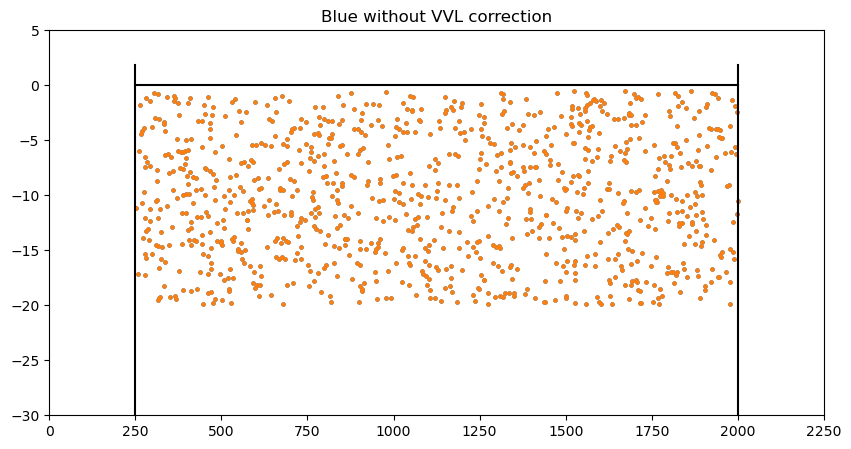

In [24]:
ss =[]
ani = anim2(dat2,dat3,fps=1)
f = r"/home/jvalenti/MOAD/animations/box.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

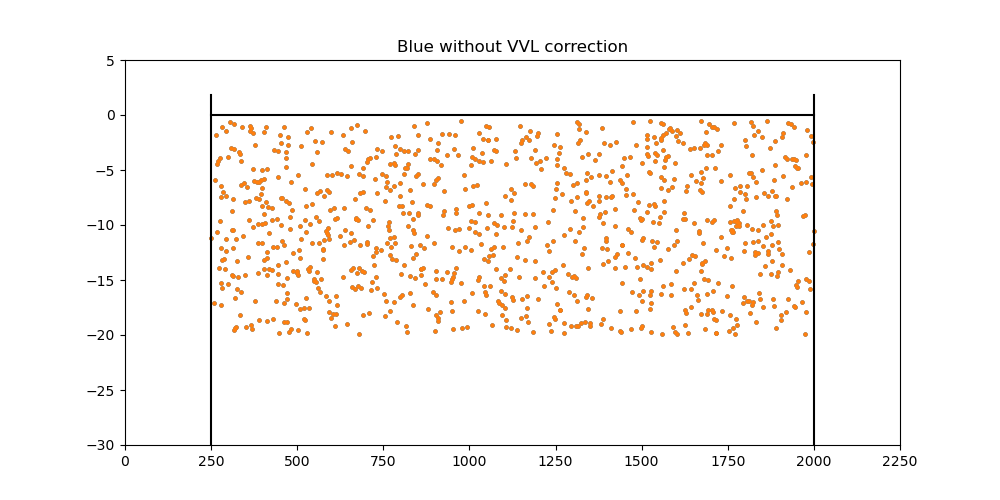

In [25]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))